In [9]:
!pip install xgboost --quiet

In [10]:
# Data handling
import pandas as pd
from google.colab import files

# numerical calculation
import numpy as np

# Utilities
import sys, os
import re

# NLP toolkits
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,LancasterStemmer

# Tranditional modelling
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Tools & Evaluation metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder

from nltk.corpus import stopwords
from textblob import TextBlob
from google.colab import drive
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from wordcloud import WordCloud
import warnings
import logging
import string
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

nltk.download('reuters') # Downloading corpus
nltk.download('stopwords') # Downloading stopwords
nltk.download('punkt') # Downloading tokenizer
nltk.download('wordnet')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
cd '/content/drive/My Drive/AIML/13_Capstone Project AIML/GitHub/automaticTicketAssignment/'

/content/drive/My Drive/AIML/13_Capstone Project AIML/GitHub/automaticTicketAssignment


In [13]:
logging.basicConfig(filename='app.log', filemode='w', format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO)
pd.set_option('display.max_colwidth', 0)
#print(Path('app.log').read_text())

## Read ticket data file as data frame

In [14]:
ticket_df = pd.read_excel('input_data.xlsx')

# Show head of the data

In [15]:
ticket_df.head()

Short description  ... Assignment group
0  login issue                    ...  GRP_0          
1  outlook                        ...  GRP_0          
2  cant log in to vpn             ...  GRP_0          
3  unable to access hr_tool page  ...  GRP_0          
4  skype error                    ...  GRP_0          

[5 rows x 4 columns]

# Shape of the data

In [16]:
ticket_df.shape

(8500, 4)

## Describe data

In [17]:
ticket_df.describe()

Short description Description             Caller Assignment group
count   8492              8499        8500               8500           
unique  7481              7817        2950               74             
top     password reset    the         bpctwhsn kzqsbmtp  GRP_0          
freq    38                56          810                3976

Ticket dataset divided into 2 parts. Dependent features like Short Description, Description and Caller; 
Target variable is Assignment group

# Find any Null values in the data 

In [18]:
ticket_df.isnull().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [19]:
ticket_df = ticket_df.fillna("")

In [20]:
ticket_df.isnull().sum()

Short description    0
Description          0
Caller               0
Assignment group     0
dtype: int64

## Find any duplicate rows in the dataframe

In [21]:
duplicate = ticket_df[ticket_df.duplicated()]
duplicate.shape

(83, 4)

In [22]:
ticket_df.drop_duplicates(inplace=True)
ticket_df.shape

(8417, 4)

#### Observations:
* The ticket dataset contains 8500 rows and 4 columns
* All 4 columns are of type 'Object'with text information
* There are 9 null values in Short description and 1 null in Description columns
* We have 83 duplicate rows in the dataset

## Analyze the distribution of Assignment Group

In [23]:
targetClassCnt=ticket_df['Assignment group'].value_counts()
targetClassCnt.head()

GRP_0     3934
GRP_8     645 
GRP_24    285 
GRP_12    257 
GRP_9     252 
Name: Assignment group, dtype: int64

In [24]:
targetClassCnt.describe()

count    74.000000  
mean     113.743243 
std      460.731077 
min      1.000000   
25%      5.250000   
50%      26.000000  
75%      81.000000  
max      3934.000000
Name: Assignment group, dtype: float64

In Target variable 'Assignment group', GRP_0 has maximum rows.

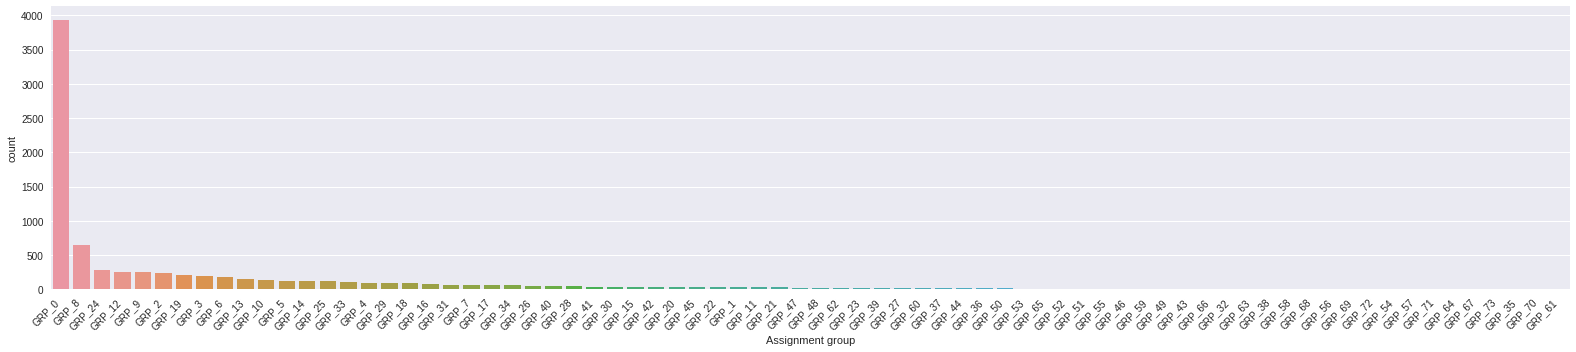

In [25]:
descending_order = ticket_df['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
ax=sns.countplot(x='Assignment group', data=ticket_df,order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

The above plot shows the distribution of all assignment groups

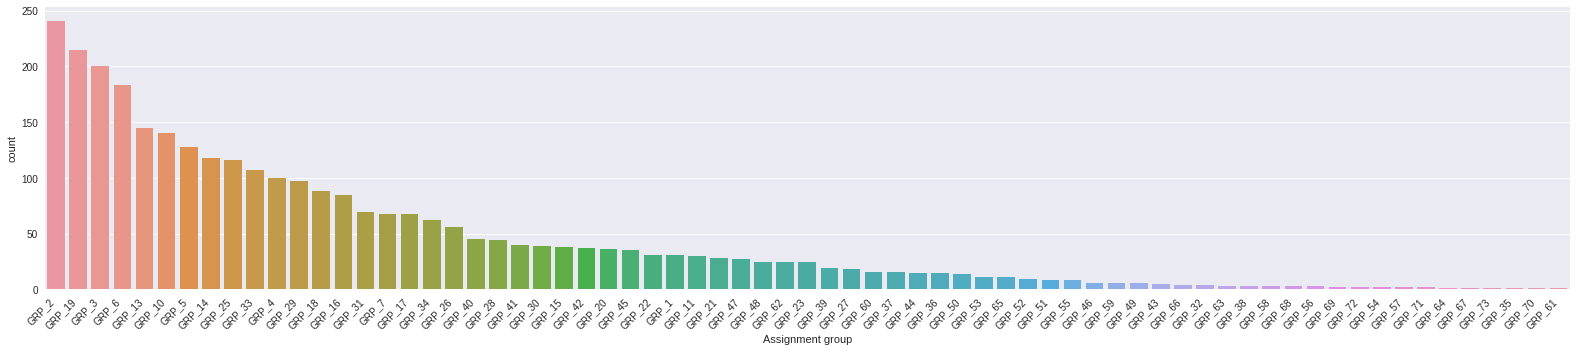

In [26]:
descending_order = ticket_df['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
ax=sns.countplot(x='Assignment group', data=ticket_df,order=descending_order[5:])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

The above plot shows the distribution of all assignment groups excluding top 5

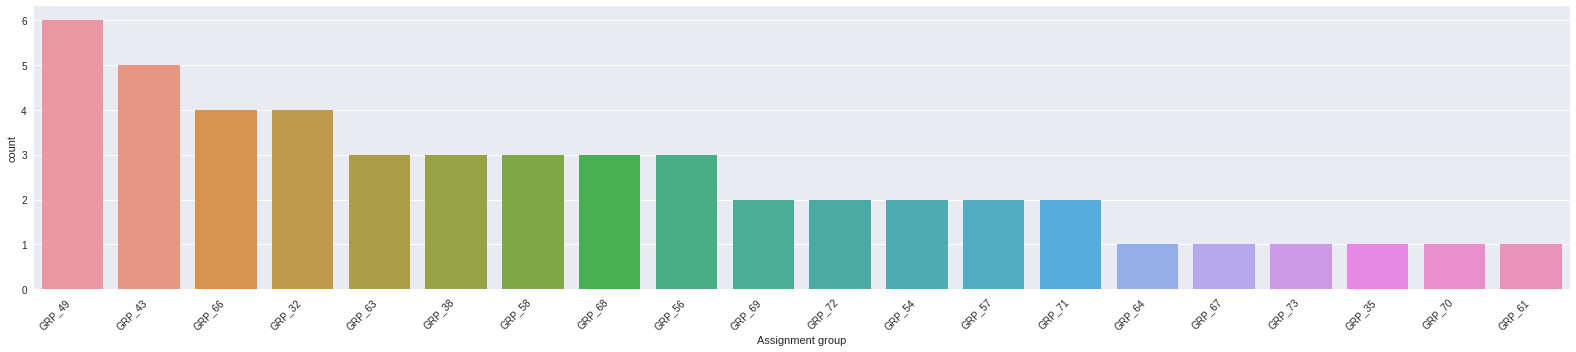

In [27]:
descending_order = ticket_df['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
ax=sns.countplot(x='Assignment group', data=ticket_df,order=descending_order[-20:])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

The above plot shows the distribution of bottom most 20 assignment groups .

As there are groups with just one ticket, we can club together all groups with less than 3 records into one group and analyze the data

In [28]:
asnGroupBy = ticket_df.groupby(['Assignment group'])
others=[]
for grp in ticket_df['Assignment group'].unique():
  if(asnGroupBy.get_group(grp).shape[0]<5):
    others.append(grp)
print('Found {} groups which have under 5 samples'.format(len(others)))
ticket_df['Assignment group']=ticket_df['Assignment group'].apply(lambda x : 'OTHERS' if x in others  else x)

ticket_df['Assignment group'].unique()

Found 18 groups which have under 5 samples


array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'OTHERS', 'GRP_36', 'GRP_37', 'GRP_39',
       'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44', 'GRP_45',
       'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50', 'GRP_51',
       'GRP_52', 'GRP_53', 'GRP_55', 'GRP_59', 'GRP_60', 'GRP_62',
       'GRP_65'], dtype=object)

## Analyse the distribution of Callers

In [29]:
callers = ticket_df['Caller'].unique() 
callers.shape

(2950,)

In [30]:
callersCntDF = ticket_df['Caller'].value_counts()
print(callersCntDF.describe())
callersCntDF.head()

count    2950.000000
mean     2.853220   
std      15.416578  
min      1.000000   
25%      1.000000   
50%      2.000000   
75%      3.000000   
max      788.000000 
Name: Caller, dtype: float64


bpctwhsn kzqsbmtp    788
ZkBogxib QsEJzdZO    151
fumkcsji sarmtlhy    128
rbozivdq gmlhrtvp    72 
rkupnshb gsmzfojw    71 
Name: Caller, dtype: int64

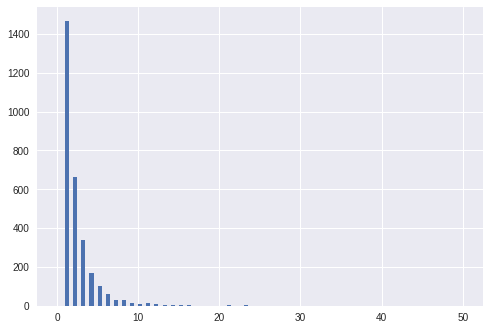

In [31]:
callersCntDF.hist(bins=100,range=(0,50))

Observation: The number of callers who reported more than 10 tickets is very less. And most of the callers have reported 1-2 tickets

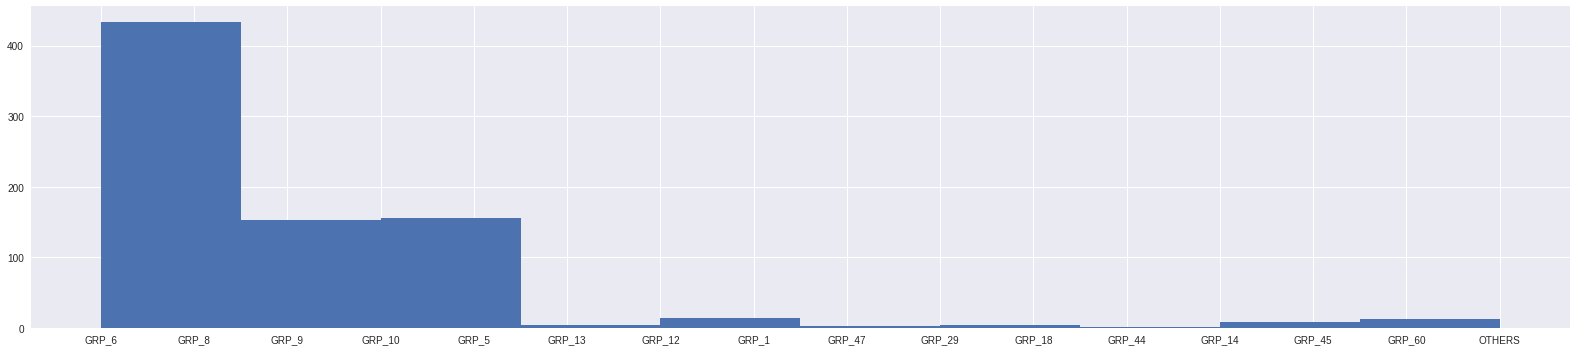

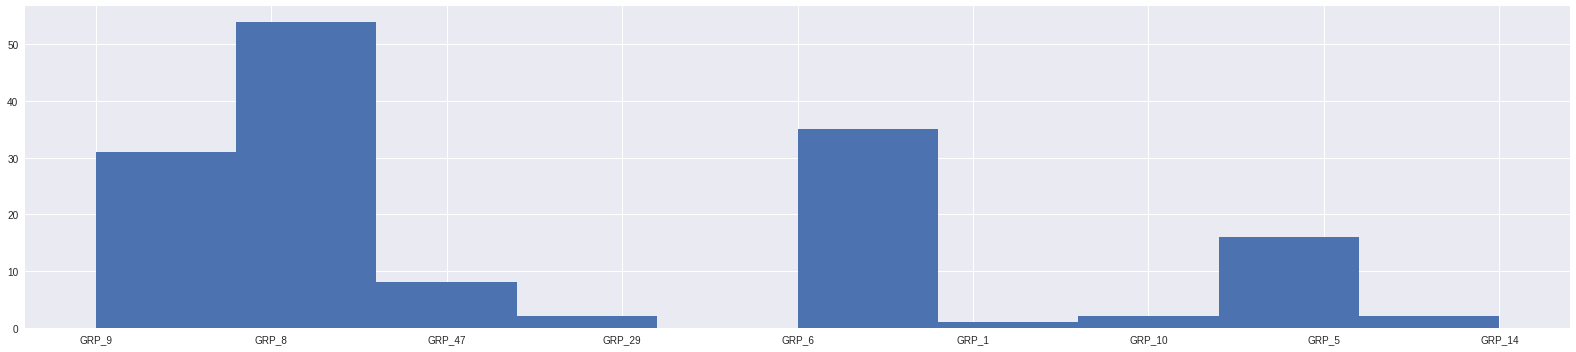

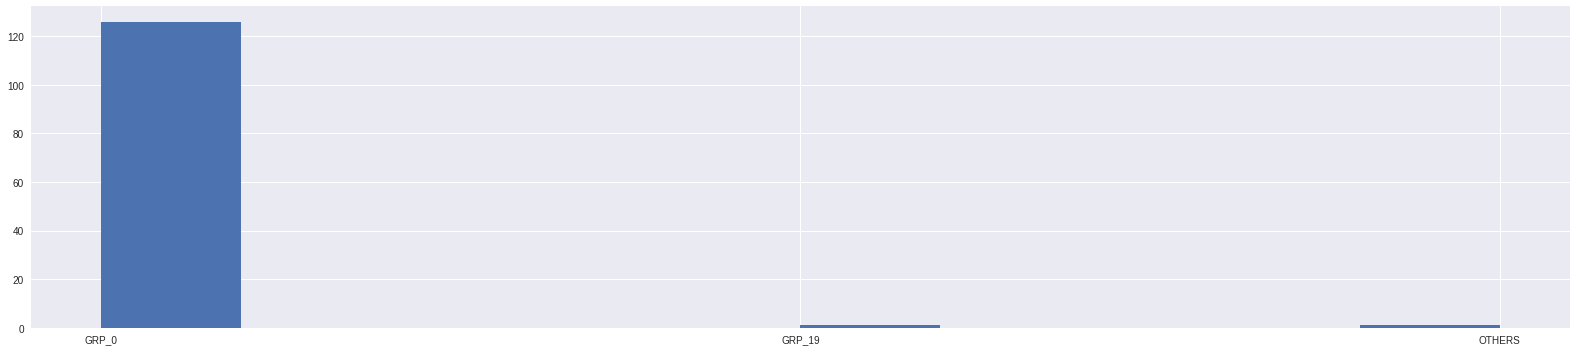

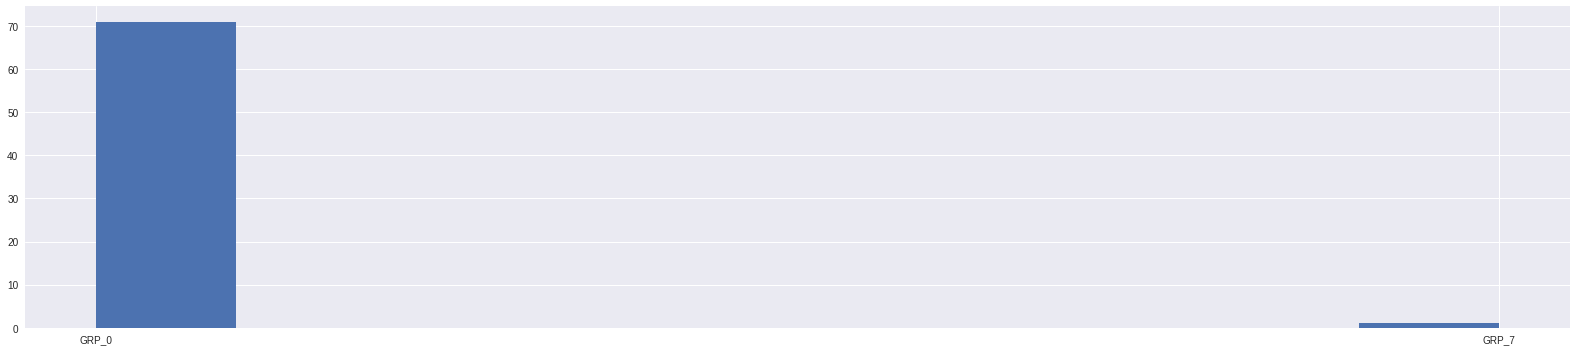

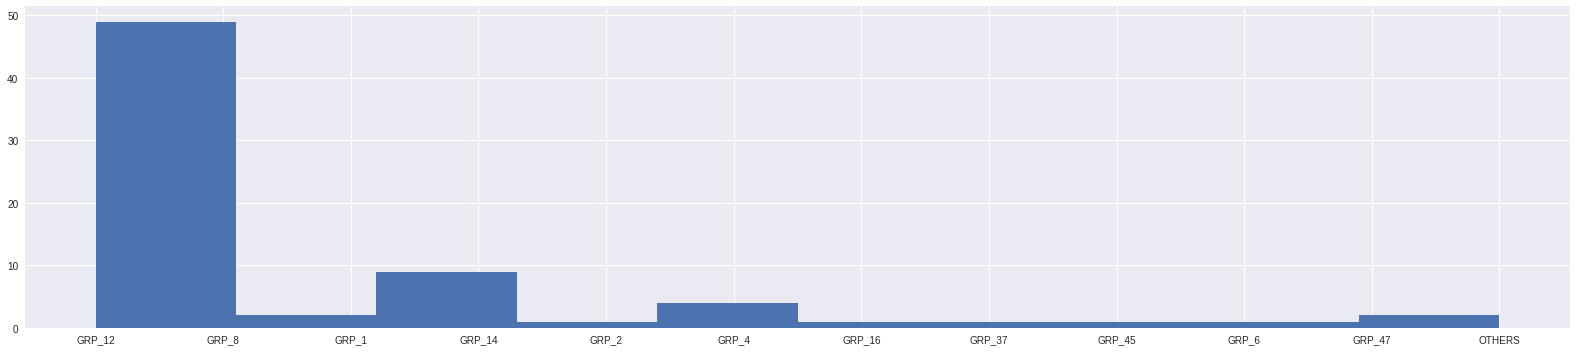

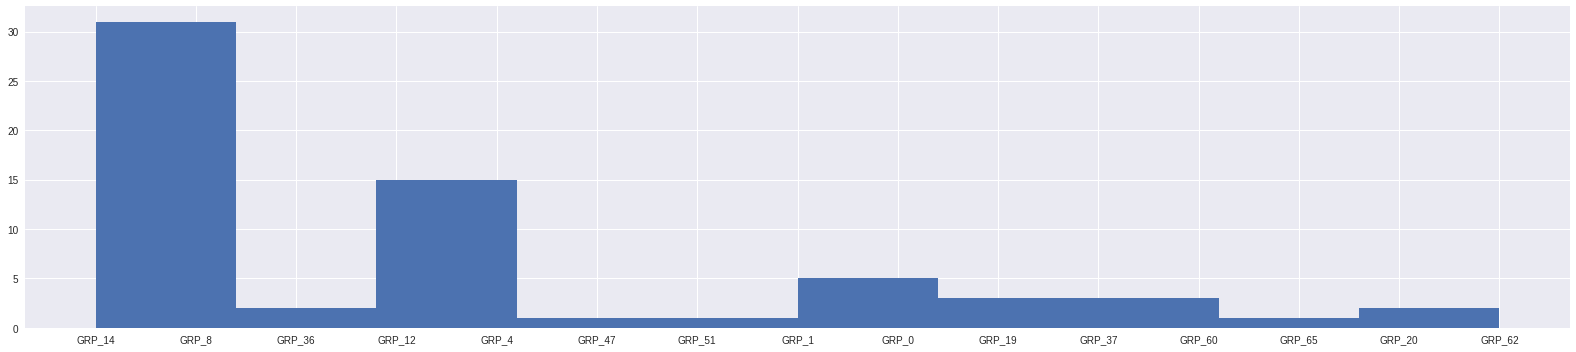

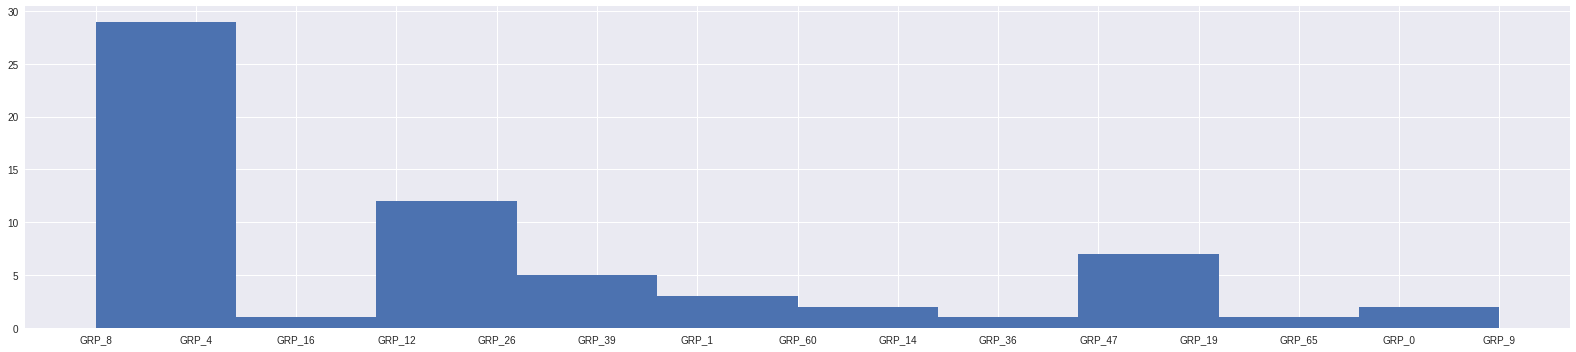

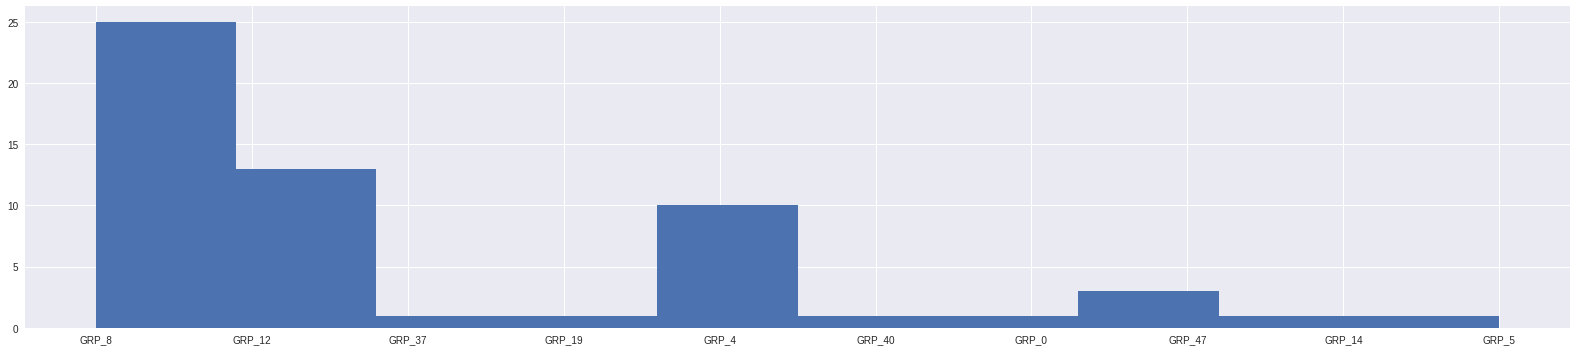

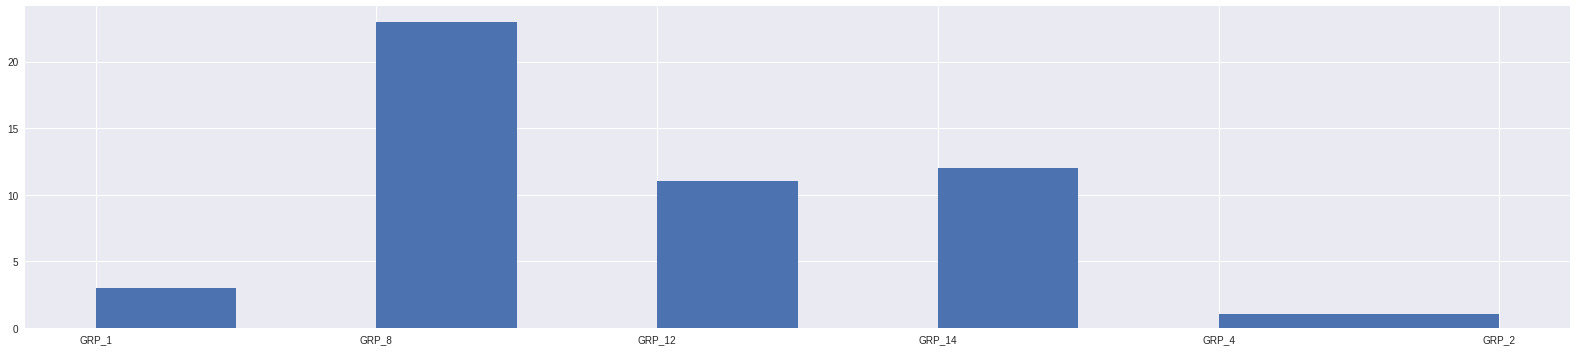

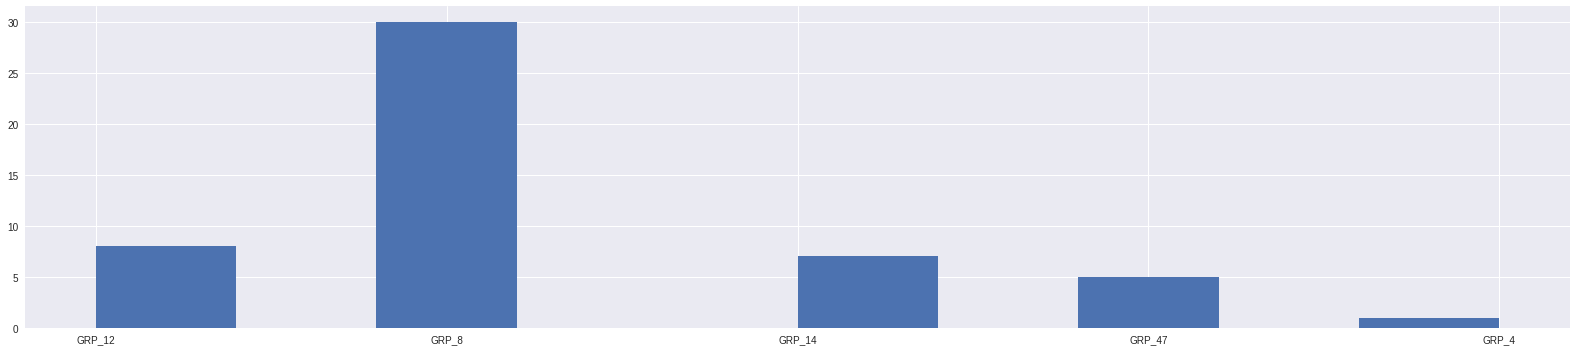

In [32]:
# look at distribution of Assignment Group for 10 most frequent callers
top_10_callers = callersCntDF.index[:10]
for caller in top_10_callers:
  assignment_groups = ticket_df[ticket_df['Caller']==caller]['Assignment group']
  plt.figure(figsize=(22,5))
  assignment_groups.hist()
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
  plt.tight_layout()
  plt.show()

#### Observation: 
* There are 2950 callers have been captured in the entire dataset. 
* The most frequent caller has raised tickets for a variety of Assignment groups.
* 15 callers are identified to be involved in raising tickets for multiple assignment groups


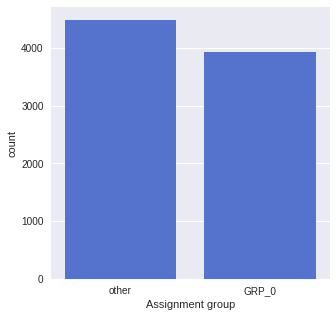

In [33]:
ticket_df_grp0 = ticket_df.copy()
ticket_df_grp0['Assignment group']=ticket_df_grp0['Assignment group'].apply(lambda x : 'other' if x != 'GRP_0'  else x)

descending_order = ticket_df_grp0['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(5,5))
sns.countplot(x='Assignment group', data=ticket_df_grp0, color='royalblue',order=descending_order)

#### Observation: 
* The above plot shows the distribution of samples of GRP_0 vs all other groups combined. 
* Large no of entries in GRP_0 (having count of 3976 entries) which account for ~50% of the data
* We need to fix the imbalance in the data using data augmentation techniques

In [34]:
ticket_df['sd_len'] = ticket_df['Short description'].astype(str).apply(len)
ticket_df['sd_word_count'] = ticket_df['Short description'].apply(lambda x: len(str(x).split()))
ticket_df['ld_len'] = ticket_df['Description'].astype(str).apply(len)
ticket_df['ld_word_count'] = ticket_df['Description'].apply(lambda x: len(str(x).split()))

In [35]:
ticket_df.head()

Short description  ... ld_word_count
0  login issue                    ...  33          
1  outlook                        ...  25          
2  cant log in to vpn             ...  11          
3  unable to access hr_tool page  ...  5           
4  skype error                    ...  2           

[5 rows x 8 columns]

In [36]:
ticket_df['sd_len'].describe()

count    8417.000000
mean     47.253059  
std      27.068818  
min      0.000000   
25%      26.000000  
50%      41.000000  
75%      62.000000  
max      159.000000 
Name: sd_len, dtype: float64

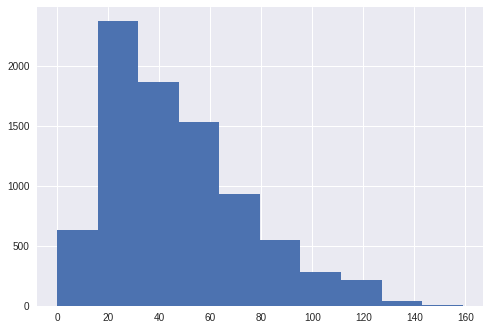

In [37]:
ticket_df['sd_len'].hist()

In [38]:
ticket_df['sd_len'].value_counts()[-20:]

131    3
127    3
133    3
125    3
145    2
141    2
137    2
144    2
135    2
159    2
138    1
2      1
151    1
140    1
1      1
136    1
149    1
134    1
142    1
150    1
Name: sd_len, dtype: int64

In [39]:
ticket_df[ticket_df['sd_len'] <= 1]

Short description  ... ld_word_count
1860  s                 ...  1           
2604                    ...  16          
3383                    ...  16          
3906                    ...  28          
3910                    ...  28          
3915                    ...  28          
3921                    ...  28          
3924                    ...  30          
4341                    ...  28          

[9 rows x 8 columns]

In [40]:
ticket_df[ticket_df['ld_len'] <= 1]

Short description Description  ... ld_len ld_word_count
1860  s                         s           ...  1      1           
4395  i am locked out of skype              ...  0      0           

[2 rows x 8 columns]

Description: There are some single character short descriptions as well. However majority of the short description is not beyound 62 characters

In [41]:
ticket_df['ld_len'].describe()

count    8417.000000 
mean     205.498753  
std      521.952353  
min      0.000000    
25%      42.000000   
50%      106.000000  
75%      203.000000  
max      13001.000000
Name: ld_len, dtype: float64

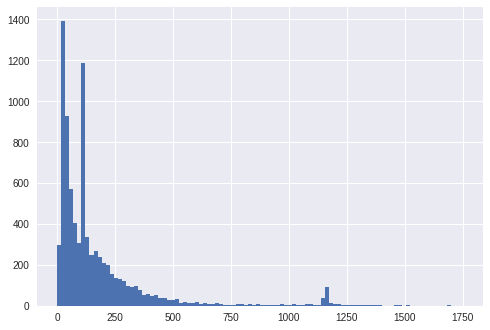

In [42]:
ticket_df['ld_len'].hist(bins=100, range=(0,1750))

In [43]:
ticket_df['ld_len'].value_counts()[-20:]

1347    1
1379    1
1387    1
1515    1
1659    1
1795    1
644     1
1839    1
4286    1
2293    1
388     1
468     1
516     1
532     1
564     1
588     1
596     1
612     1
628     1
0       1
Name: ld_len, dtype: int64

Description: There are some single character descriptions as well. However majority of the short description is not beyound 201 characters

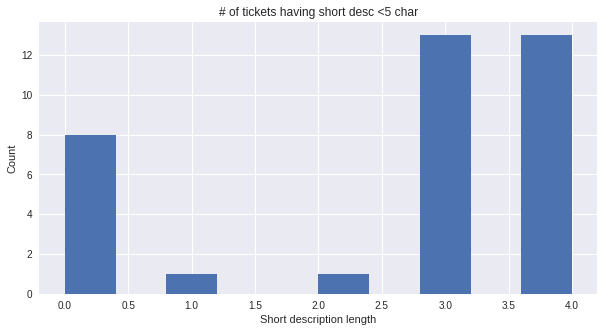

In [44]:
sd_len_FiveChar = ticket_df[ticket_df["sd_len"] < 5]
plt.xlabel('Short description length')
plt.ylabel('Count')
plt.title('# of tickets having short desc <5 char')
sd_len_FiveChar['sd_len'].hist(bins=10, figsize=(10,5))

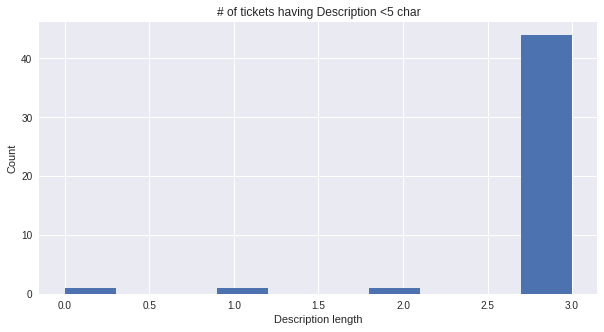

In [45]:
sd_len_FiveChar = ticket_df[ticket_df["ld_len"] < 5]
plt.xlabel('Description length')
plt.ylabel('Count')
plt.title('# of tickets having Description <5 char')
sd_len_FiveChar['ld_len'].hist(bins=10, figsize=(10,5))

In [46]:
ticket_df_temp =  ticket_df.copy()
ticket_df_temp['num_words'] = ticket_df['Description'].apply(lambda x : len(x.split()))
ticket_df_temp.describe()

sd_len  sd_word_count        ld_len  ld_word_count    num_words
count  8417.000000  8417.000000    8417.000000   8417.000000    8417.000000
mean   47.253059    6.939290       205.498753    27.471902      27.471902  
std    27.068818    4.133266       521.952353    65.319593      65.319593  
min    0.000000     0.000000       0.000000      0.000000       0.000000   
25%    26.000000    4.000000       42.000000     6.000000       6.000000   
50%    41.000000    6.000000       106.000000    11.000000      11.000000  
75%    62.000000    9.000000       203.000000    28.000000      28.000000  
max    159.000000   28.000000      13001.000000  1625.000000    1625.000000

Text(0.5, 1.0, 'Word distribution per bin')

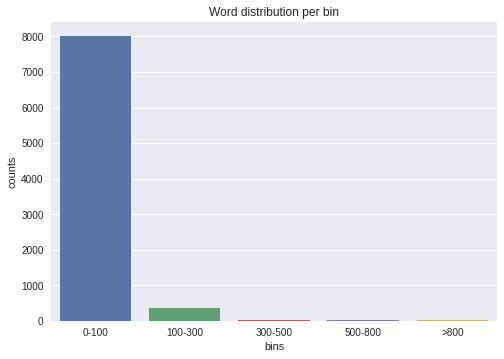

In [47]:
ticket_df_temp['bins']=pd.cut(ticket_df_temp.num_words, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>800'])
word_distribution = ticket_df_temp.groupby('bins').size().reset_index().rename(columns={0:'counts'})
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

Observation: Most of the samples had word count within 100

Common class/methods for data cleansing 
* Convert each character in a sentence to lowercase character
* Remove HTML Tags
* Remove Email contacts
* Remove punctuations, hyperlinks
* Remove stopwords
* Remove common words like com, hello
* Remove New line characters
* Stemming was causing invalid words, hence used a lemmatizer

In [48]:
class PreProcessing:
    lemmatizer=""
    stemmer =""
    tokenizer=""
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = LancasterStemmer()
        self.tokenizer = RegexpTokenizer(r'\w+')
    
    def data_clean(self, sentence):
      if pd.isnull(sentence):
        return sentence
      sentence= sentence.lower()
      sentence = ' '.join([w for w in sentence.split() if not self.is_valid_date(w)])
      sentence = re.sub(r"received from:",' ',sentence)
      sentence = re.sub(r"select the following link to view the disclaimer in an alternate language.",' ',sentence)
      sentence = re.sub(r"from:",' ',sentence)
      sentence = re.sub(r"to:",' ',sentence)
      sentence = re.sub(r"subject:",' ',sentence)
      sentence = re.sub(r"re:",' ',sentence)
      sentence = re.sub(r"fw:",' ',sentence)
      sentence = re.sub(r"sent:",' ',sentence)
      sentence = re.sub(r"ic:",' ',sentence)
      sentence = re.sub(r"cc:",' ',sentence)
      sentence = re.sub(r"bcc:",' ',sentence)
      #Remove email 
      sentence = re.sub(r'\S*@\S*\s?', '', sentence)
      # Remove underscores
      sentence = re.sub(r'\_',' ', sentence)

      # Remove new line characters 
      sentence = re.sub(r'\n',' ',sentence)
      # Remove hashtag while keeping hashtag sentence
      sentence = re.sub(r'#','', sentence)
      #& 
      sentence = re.sub(r'&;?', 'and',sentence)
      # Remove HTML special entities (e.g. &amp;)
      sentence = re.sub(r'\&\w*;', '', sentence)
      # Remove hyperlinks
      sentence = re.sub(r'https?:\/\/.*\/\w*', '', sentence)  
      # Remove characters beyond Readable formart by Unicode:
      sentence= ''.join(c for c in sentence if c <= '\uFFFF') 
      sentence = sentence.strip()
      # Remove unreadable characters  (also extra spaces)
      sentence = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", sentence).split())

      # Single character      
      sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
      sentence = sentence.strip()
      return sentence
    
    def is_valid_date(self,date_str):
      try:
        parser.parse(date_str)
        return True
      except:
        return False
    
    def mergeColumns(self, df):
        df['desc']=df['Short description'] + " " + df['Description']
        df.drop("Short description", axis=1, inplace=True)
        df.drop("Description", axis=1, inplace=True)
        df.drop("Caller", axis=1, inplace=True)
        return df

    def remove_punctuation(self, sentence):
      try:
        no_punct = "".join([c for c in sentence if c not in string.punctuation])
        return no_punct
      except:
        print("remove_punctuation: sentence,",sentence)
        return sentence

    def make_tokens(self, sentence):
      return self.tokenizer.tokenize(sentence.lower())

    def remove_stopwords(self, words):
      return [w for w in words if w not in stopwords.words('english')]

    def word_lemmatize(self, words):
      return [self.lemmatizer.lemmatize(item) for item in words]


preProcessing=PreProcessing()

In [49]:
# merging two description columns and doing cleaning
ticket_df=preProcessing.mergeColumns(ticket_df)
ticket_df['desc_clean'] = ticket_df['desc'].apply(preProcessing.data_clean)

In [50]:
ticket_df.head()

Assignment group  ...                                                                                                                                                                                                    desc_clean
0  GRP_0            ...  login issue verified user details employee and manager name checked the user name in ad and reset the password advised the user to login and check caller confirmed that he was able to login issue resolved
1  GRP_0            ...  outlook hello team my meetings skype meetings etc are not appearing in my outlook calendar can somebody please advise how to correct this kind                                                              
2  GRP_0            ...  cant log in to vpn hi cannot log on to vpn best                                                                                                                                                             
3  GRP_0            ...  unable to access hr tool page unable to access hr tool page                                                                                                                                                 
4  GRP_0            ...  skype error skype error                                                                                                                                                                                     

[5 rows x 7 columns]

In [51]:
ticket_df['desc_punct'] = ticket_df['desc_clean'].map(preProcessing.remove_punctuation)
ticket_df['desc_token'] = ticket_df['desc_punct'].map(preProcessing.make_tokens)
ticket_df['desc_stop'] = ticket_df['desc_token'].map(preProcessing.remove_stopwords)
ticket_df['desc_lemma'] = ticket_df['desc_stop'].map(preProcessing.word_lemmatize)

In [52]:
ticket_df.head()

Assignment group  ...                                                                                                                                                                               desc_lemma
0  GRP_0            ...  [login, issue, verified, user, detail, employee, manager, name, checked, user, name, ad, reset, password, advised, user, login, check, caller, confirmed, able, login, issue, resolved]
1  GRP_0            ...  [outlook, hello, team, meeting, skype, meeting, etc, appearing, outlook, calendar, somebody, please, advise, correct, kind]                                                            
2  GRP_0            ...  [cant, log, vpn, hi, cannot, log, vpn, best]                                                                                                                                           
3  GRP_0            ...  [unable, access, hr, tool, page, unable, access, hr, tool, page]                                                                                                                       
4  GRP_0            ...  [skype, error, skype, error]                                                                                                                                                           

[5 rows x 11 columns]

In [53]:
combined_desc = ticket_df['desc_stop'].values.tolist()

In [54]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(combined_desc))

In [55]:
data_words[:3]

[['login',
  'issue',
  'verified',
  'user',
  'details',
  'employee',
  'manager',
  'name',
  'checked',
  'user',
  'name',
  'ad',
  'reset',
  'password',
  'advised',
  'user',
  'login',
  'check',
  'caller',
  'confirmed',
  'able',
  'login',
  'issue',
  'resolved'],
 ['outlook',
  'hello',
  'team',
  'meetings',
  'skype',
  'meetings',
  'etc',
  'appearing',
  'outlook',
  'calendar',
  'somebody',
  'please',
  'advise',
  'correct',
  'kind'],
 ['cant', 'log', 'vpn', 'hi', 'cannot', 'log', 'vpn', 'best']]

In [56]:
data_words[1][2]

'team'

In [57]:
all_words = []
for i in range(len(data_words)): #Traversing through the main list
  for j in range (len(data_words[i])): #Traversing through each sublist
    all_words.append(data_words[i][j])

In [58]:
all_words[:5]

['login', 'issue', 'verified', 'user', 'details']

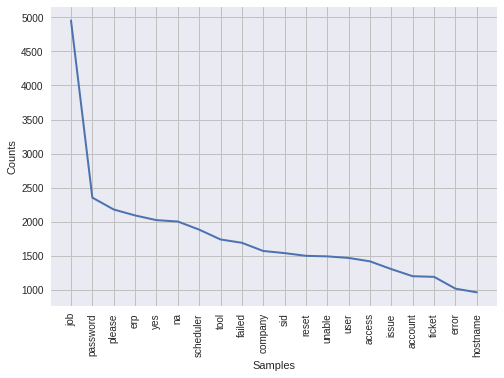

In [59]:
word_freq = nltk.FreqDist(all_words)
word_freq.plot(20)

In [60]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_bigrams = make_bigrams(data_words)    
print(data_words_bigrams[1])

['outlook', 'hello', 'team', 'meetings', 'skype', 'meetings', 'etc', 'appearing', 'outlook', 'calendar', 'somebody', 'please', 'advise', 'correct', 'kind']


In [61]:
wordclouds=' '.join(map(str, data_words_bigrams)) 

In [62]:
wordclouds

"['login', 'issue', 'verified', 'user', 'details', 'employee', 'manager', 'name', 'checked', 'user', 'name', 'ad', 'reset', 'password', 'advised', 'user', 'login', 'check', 'caller_confirmed', 'able', 'login', 'issue', 'resolved'] ['outlook', 'hello', 'team', 'meetings', 'skype', 'meetings', 'etc', 'appearing', 'outlook', 'calendar', 'somebody', 'please', 'advise', 'correct', 'kind'] ['cant', 'log', 'vpn', 'hi', 'cannot', 'log', 'vpn', 'best'] ['unable', 'access', 'hr', 'tool', 'page', 'unable', 'access', 'hr', 'tool', 'page'] ['skype', 'error', 'skype', 'error'] ['unable', 'log', 'engineering', 'tool', 'skype', 'unable', 'log', 'engineering', 'tool', 'skype'] ['event', 'critical', 'hostname', 'company', 'com', 'value', 'mountpoint', 'threshold', 'oracle', 'sid', 'erpdata', 'event', 'critical', 'hostname', 'company', 'com', 'value', 'mountpoint', 'threshold', 'oracle', 'sid', 'erpdata', 'sr', 'psa', 'sr', 'psa', 'data', 'perpsr', 'psa'] ['ticket', 'no', 'employment_status', 'new', 'non

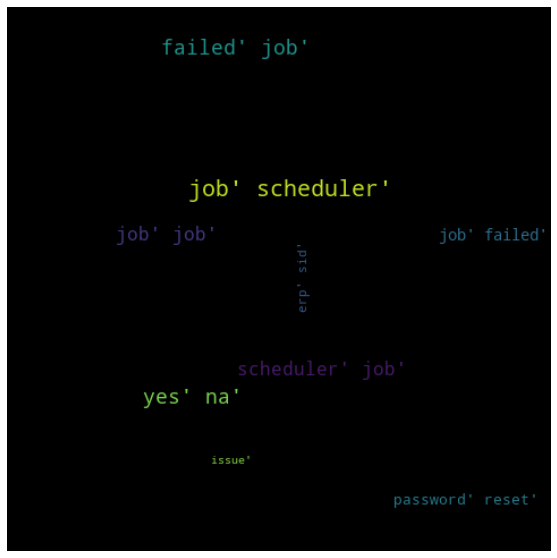

In [63]:
wordcloud = WordCloud(width=480, height=480, max_font_size=20, min_font_size=10).generate(wordclouds)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

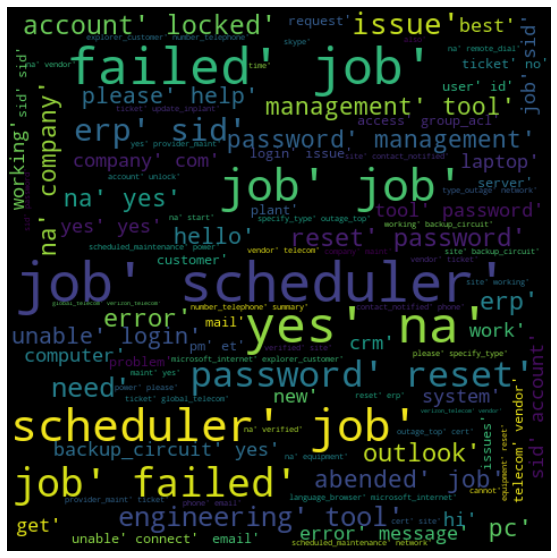

In [64]:
wordcloud_2 = WordCloud(width=480, height=480, max_words=100).generate(wordclouds)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud_2, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [65]:
def wordcloud_grp(f, x):
    wordclouds_by_grp =' '.join(map(str, f))
    wc = WordCloud(width=480, height=480, max_font_size=20, min_font_size=10, max_words=50).generate(wordclouds_by_grp)
    plt.figure(figsize=(20,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Most common 50 words of {}".format(x))
    plt.margins(x=0, y=0)
    plt.show()

In [66]:
value = targetClassCnt.sort_values(ascending=False).index
value

Index(['GRP_0', 'GRP_8', 'GRP_24', 'GRP_12', 'GRP_9', 'GRP_2', 'GRP_19',
       'GRP_3', 'GRP_6', 'GRP_13', 'GRP_10', 'GRP_5', 'GRP_14', 'GRP_25',
       'GRP_33', 'GRP_4', 'GRP_29', 'GRP_18', 'GRP_16', 'GRP_31', 'GRP_7',
       'GRP_17', 'GRP_34', 'GRP_26', 'GRP_40', 'GRP_28', 'GRP_41', 'GRP_30',
       'GRP_15', 'GRP_42', 'GRP_20', 'GRP_45', 'GRP_22', 'GRP_1', 'GRP_11',
       'GRP_21', 'GRP_47', 'GRP_48', 'GRP_62', 'GRP_23', 'GRP_39', 'GRP_27',
       'GRP_60', 'GRP_37', 'GRP_44', 'GRP_36', 'GRP_50', 'GRP_53', 'GRP_65',
       'GRP_52', 'GRP_51', 'GRP_55', 'GRP_46', 'GRP_59', 'GRP_49', 'GRP_43',
       'GRP_66', 'GRP_32', 'GRP_63', 'GRP_38', 'GRP_58', 'GRP_68', 'GRP_56',
       'GRP_69', 'GRP_72', 'GRP_54', 'GRP_57', 'GRP_71', 'GRP_64', 'GRP_67',
       'GRP_73', 'GRP_35', 'GRP_70', 'GRP_61'],
      dtype='object')

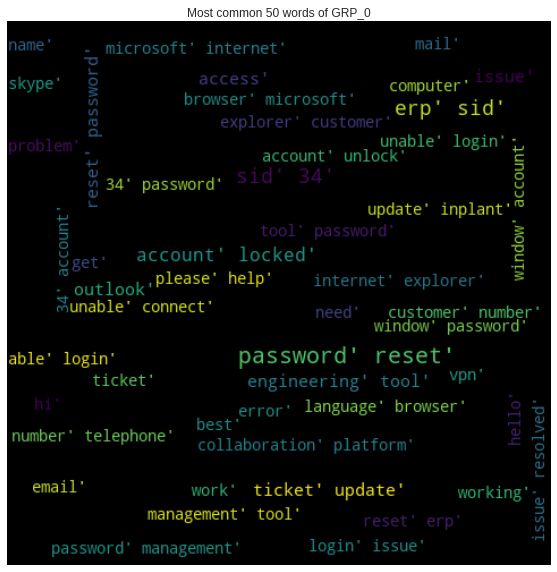

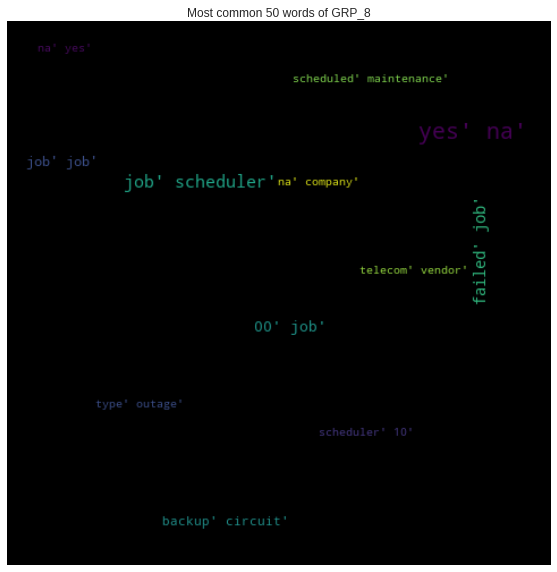

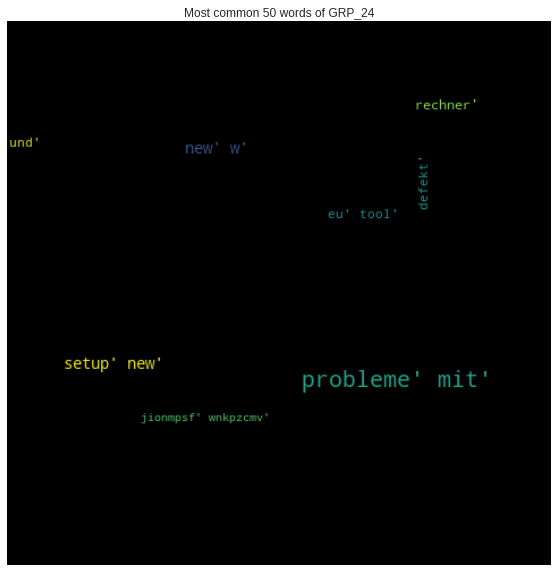

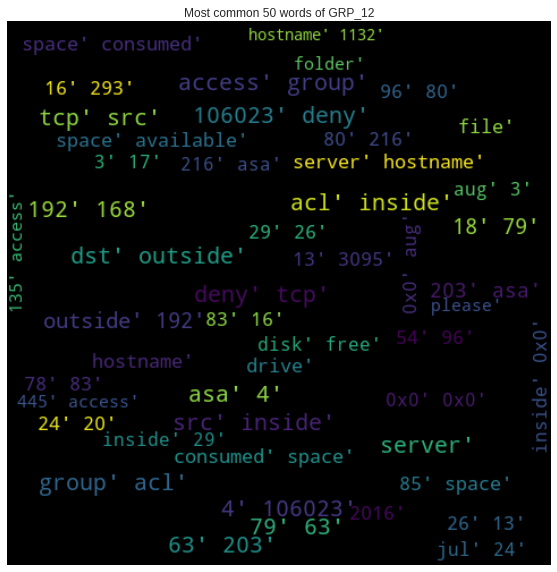

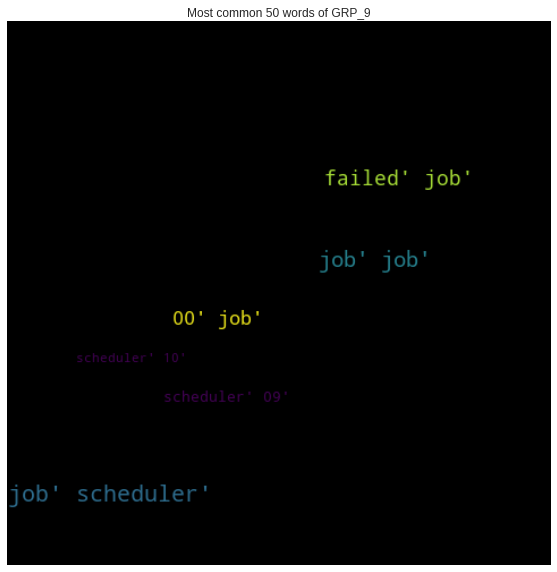

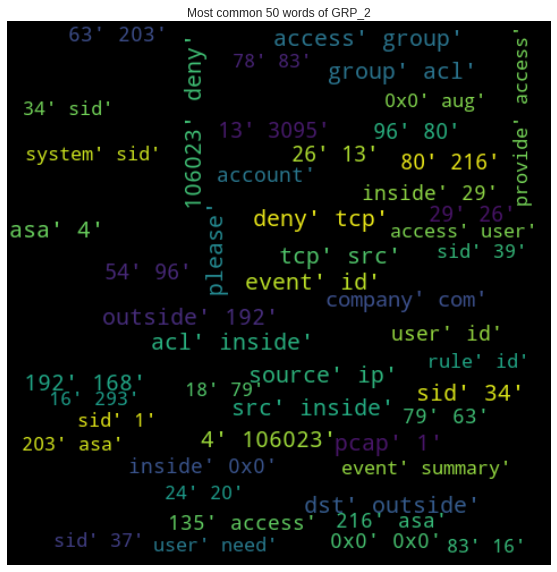

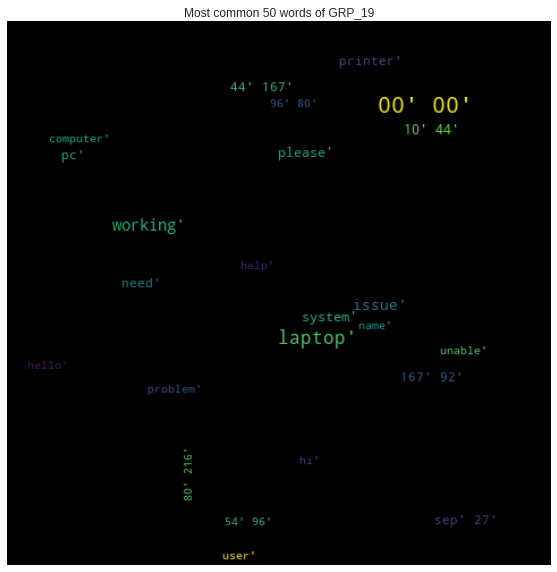

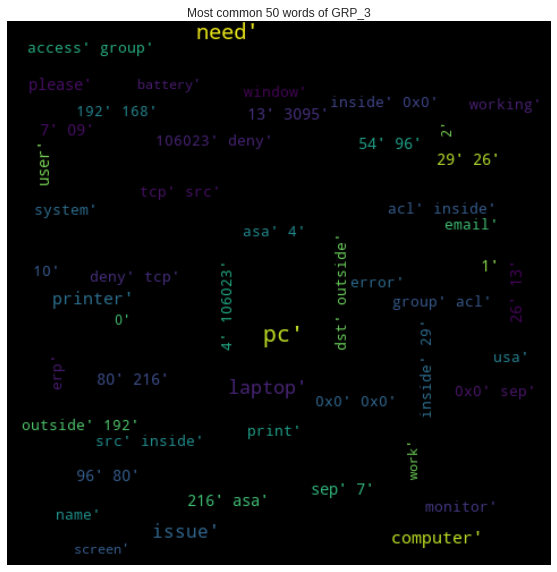

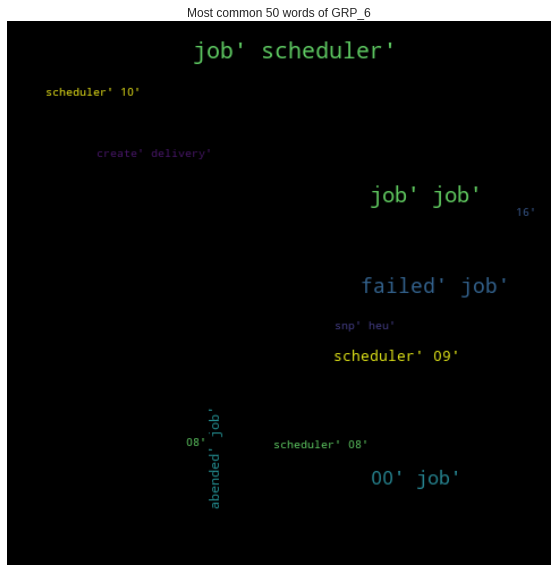

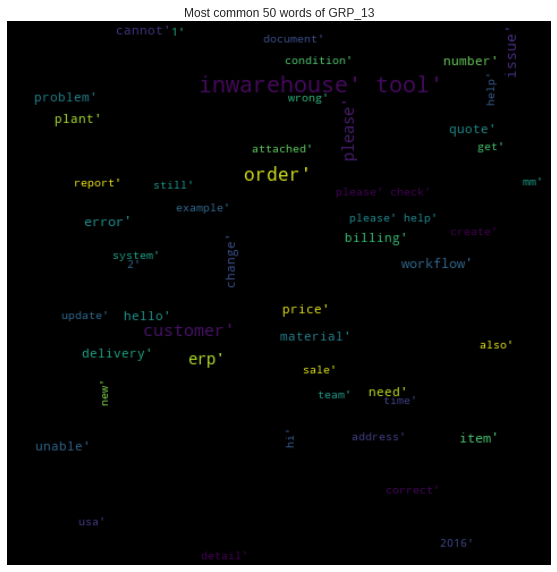

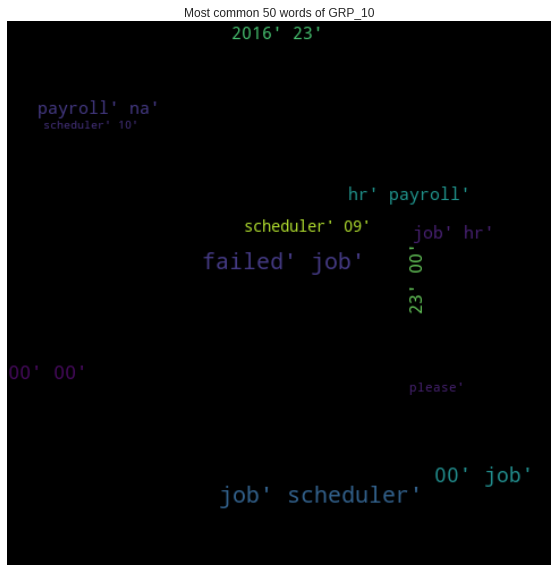

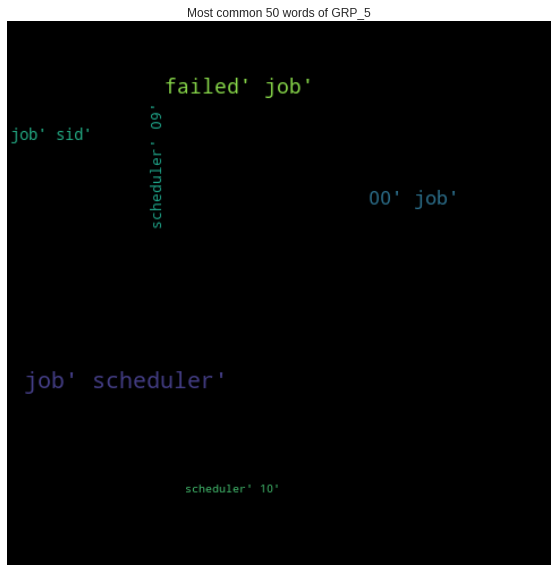

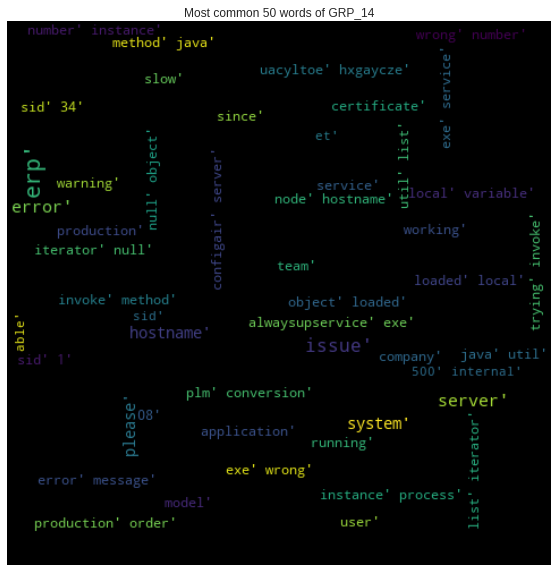

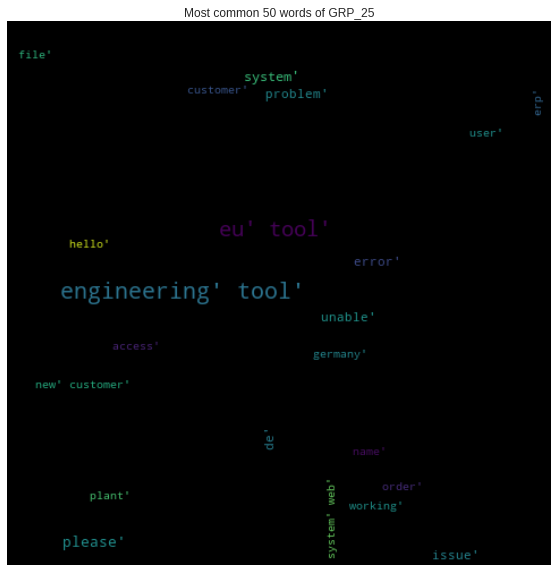

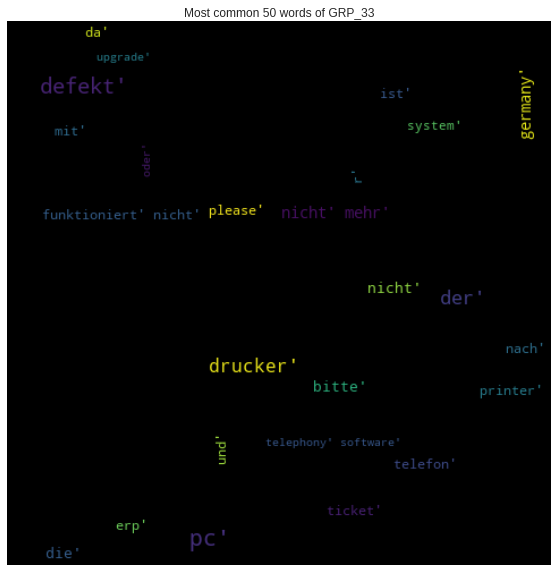

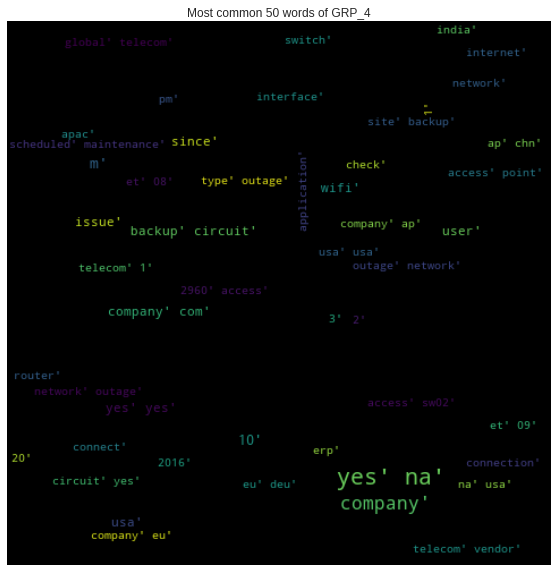

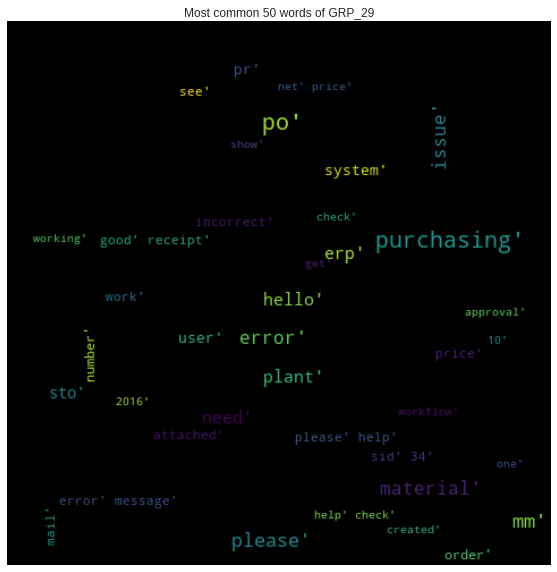

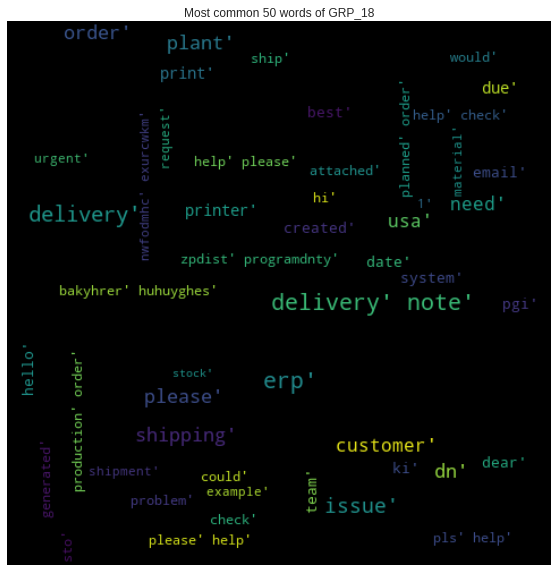

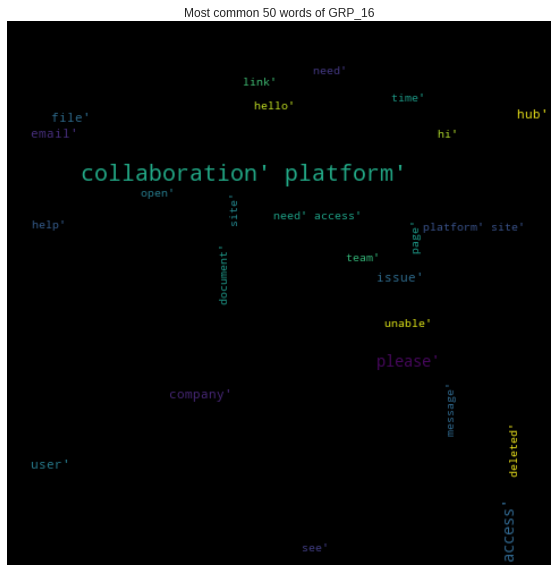

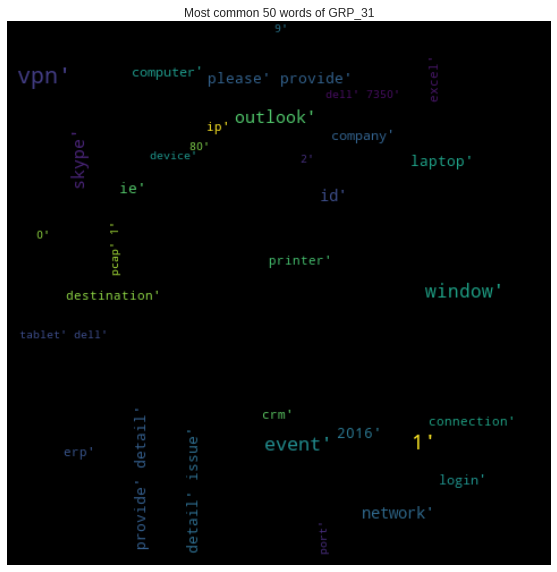

In [67]:
for i in range(20):
    Grp = ticket_df[ticket_df ['Assignment group'] == value[i]]
    Grp = Grp['desc_lemma']
    wordcloud_grp(Grp,value[i])

In [68]:
X=ticket_df['desc_lemma'].apply(lambda x: ' '.join(x))
y=ticket_df['Assignment group']

In [69]:
X

0       login issue verified user detail employee manager name checked user name ad reset password advised user login check caller confirmed able login issue resolved
1       outlook hello team meeting skype meeting etc appearing outlook calendar somebody please advise correct kind                                                   
2       cant log vpn hi cannot log vpn best                                                                                                                           
3       unable access hr tool page unable access hr tool page                                                                                                         
4       skype error skype error                                                                                                                                       
                 ...                                                                                                                                                 

In [70]:
y

0       GRP_0 
1       GRP_0 
2       GRP_0 
3       GRP_0 
4       GRP_0 
        ...   
8495    GRP_29
8496    GRP_0 
8497    GRP_0 
8498    GRP_62
8499    GRP_49
Name: Assignment group, Length: 8417, dtype: object

In [71]:
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer(lowercase=True, stop_words="english")
# X = vectorizer.fit_transform(X)

In [72]:
le = LabelEncoder() 
le.fit(y)
y = le.transform(y)

In [73]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(binary=False, norm='l2', use_idf=True, smooth_idf=True, min_df=1,max_df=1.0,max_features=None,ngram_range=(1,1), stop_words='english')
tfidf.fit(X)
X = tfidf.transform(X)

In [74]:
print(X.shape)

(8417, 18838)


In [75]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = SelectKBest(score_func=chi2,k=5000).fit_transform(X, y)

In [76]:
print(X.shape)

(8417, 5000)


In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [78]:
def precision_recall_fscore_support_roc_auc(model, y_test,X_test):
  y_pred = model.predict(X_test)

  precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')
  print("Precision: ",precision)
  print("Recall: ",recall)
  print('F1 score: ',f1_score)

  y_proba = model.predict_proba(X_test)

  print("roc_auc value: ",roc_auc_score(y_test, y_proba, labels = clf.classes_, average='macro', multi_class='ovo'))
  cf_matrix = confusion_matrix(y_test, y_pred)
  # print('Confusion matrix:\n %s' % (cf_matrix))
  plt.subplots(figsize=(25,10))
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 12}, cmap='Oranges')

train acc:  0.6686470887794942
test acc:  0.610055423594616
Precision:  0.610055423594616
Recall:  0.610055423594616
F1 score:  0.610055423594616
roc_auc value:  0.8550596961521091


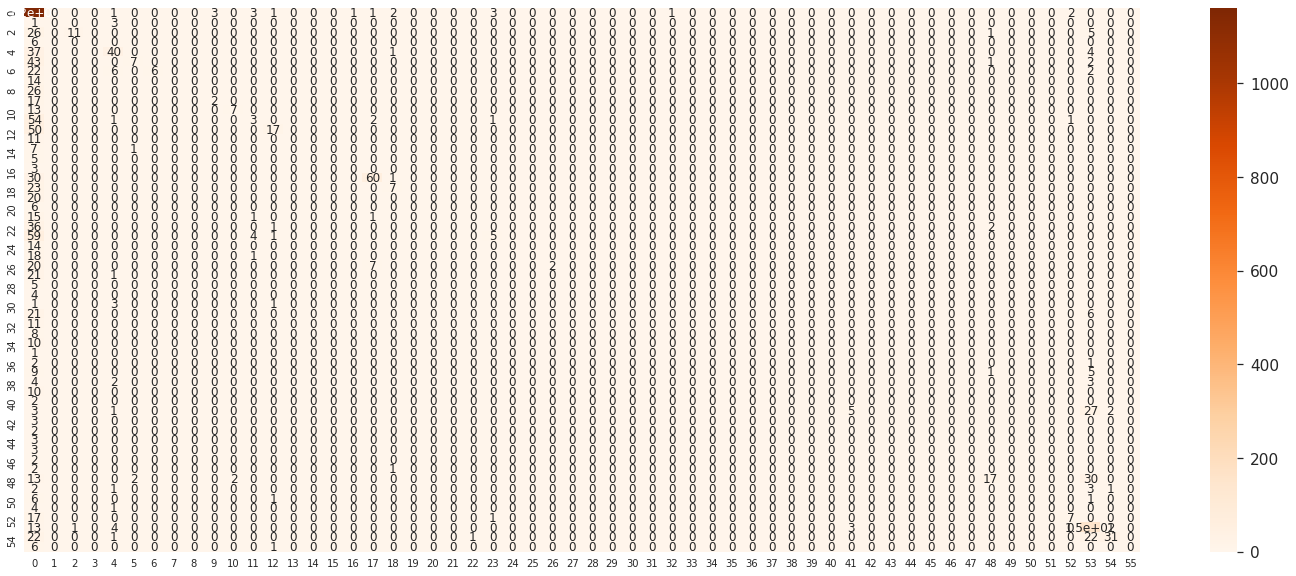

In [79]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print('train acc: ',clf.score(X_train,y_train))
print('test acc: ',clf.score(X_test, y_test))
precision_recall_fscore_support_roc_auc(clf,y_test,X_test)

train acc:  0.984382957053132
test acc:  0.6543942992874109
Precision:  0.6543942992874109
Recall:  0.6543942992874109
F1 score:  0.6543942992874109
roc_auc value:  0.7970925357415658


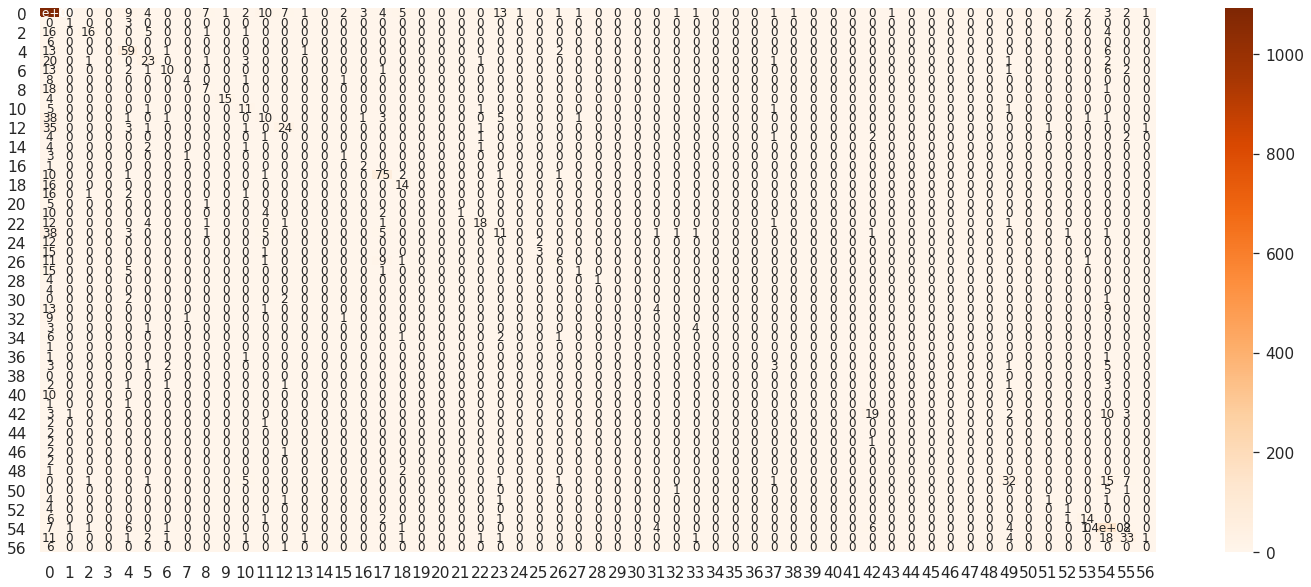

In [80]:
clf = RandomForestClassifier(n_estimators = 20, random_state=1,max_features=1.0).fit(X_train, y_train)
print('train acc: ',clf.score(X_train,y_train))
print('test acc: ',clf.score(X_test, y_test))
precision_recall_fscore_support_roc_auc(clf,y_test,X_test)

train acc:  0.8102189781021898
test acc:  0.6163895486935868
Precision:  0.6163895486935868
Recall:  0.6163895486935868
F1 score:  0.6163895486935868
roc_auc value:  0.6631462477302359


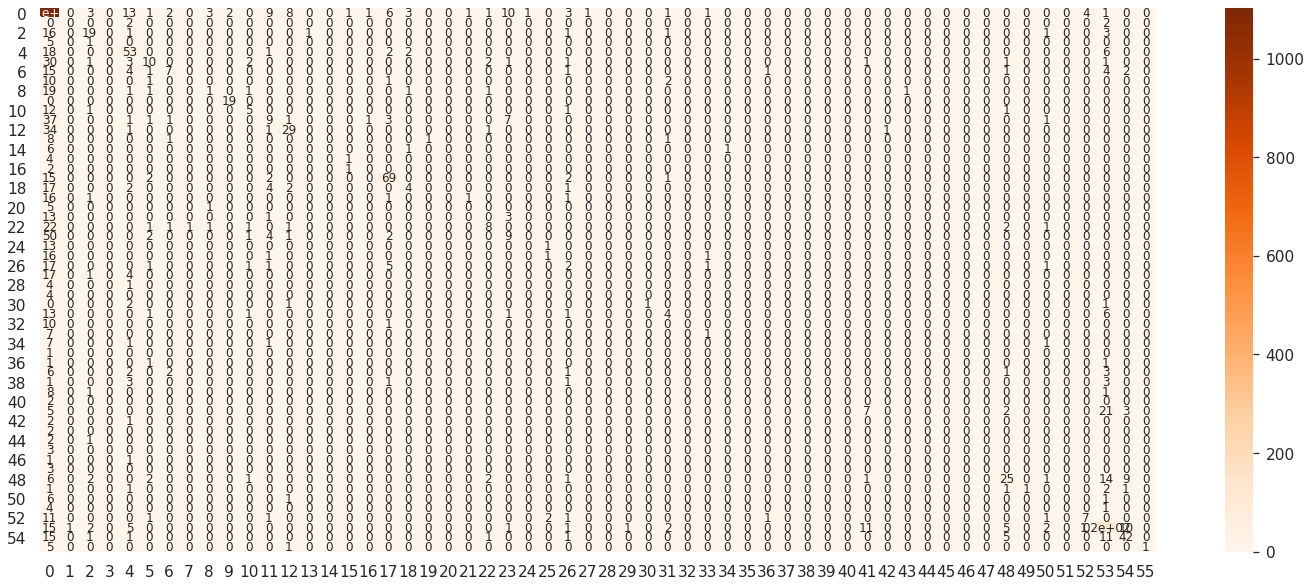

In [81]:
estimators = [
     ('rf', KNeighborsClassifier(n_neighbors= 5, weights = 'distance')),
     ('svr',SVC(C=2,gamma = 'auto', kernel= 'poly', degree=2),
     LogisticRegression(solver="liblinear"))]
clf = StackingClassifier(estimators=estimators, 
                         final_estimator=RandomForestClassifier(n_estimators = 20, random_state=1,max_features=1.0)).fit(X_train, y_train)
print('train acc: ',clf.score(X_train,y_train))
print('test acc: ',clf.score(X_test, y_test))
precision_recall_fscore_support_roc_auc(clf,y_test,X_test)

train acc:  0.9925309794601935
test acc:  0.6001583531274742
Precision:  0.6001583531274742
Recall:  0.6001583531274742
F1 score:  0.6001583531274742
roc_auc value:  0.6328491235926601


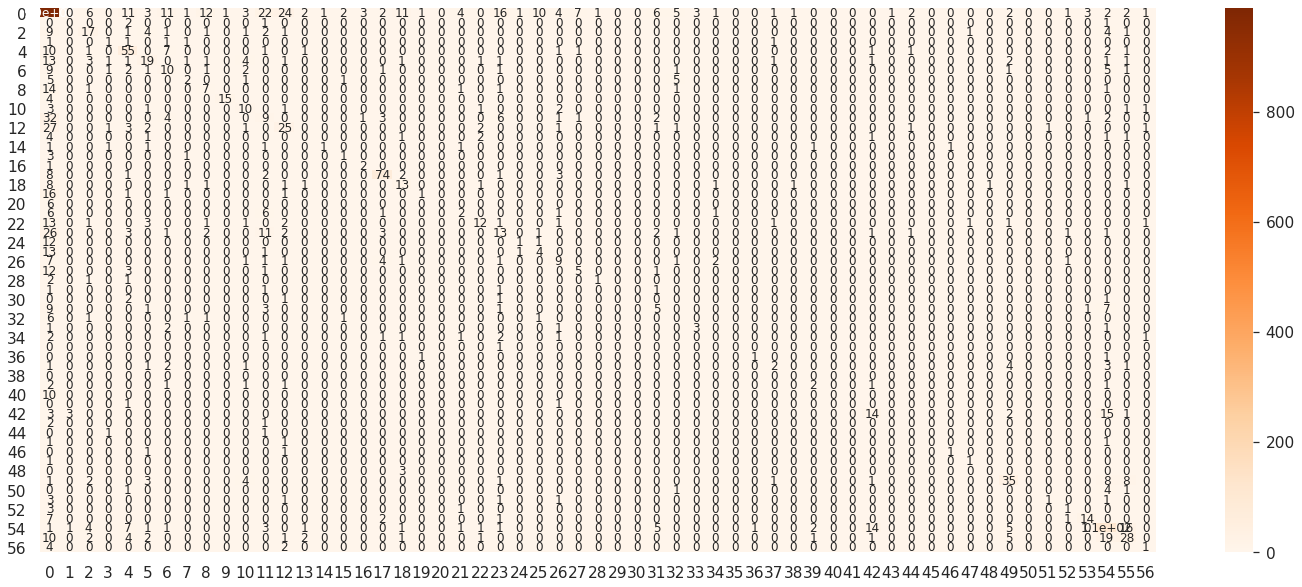

In [82]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1).fit(X_train, y_train)
print('train acc: ',dTree.score(X_train,y_train))
print('test acc: ',dTree.score(X_test, y_test))
precision_recall_fscore_support_roc_auc(dTree,y_test,X_test)

train acc:  0.9893057205907316
test acc:  0.6555819477434679
Precision:  0.6555819477434679
Recall:  0.6555819477434679
F1 score:  0.6555819477434679
roc_auc value:  0.7911961231691671


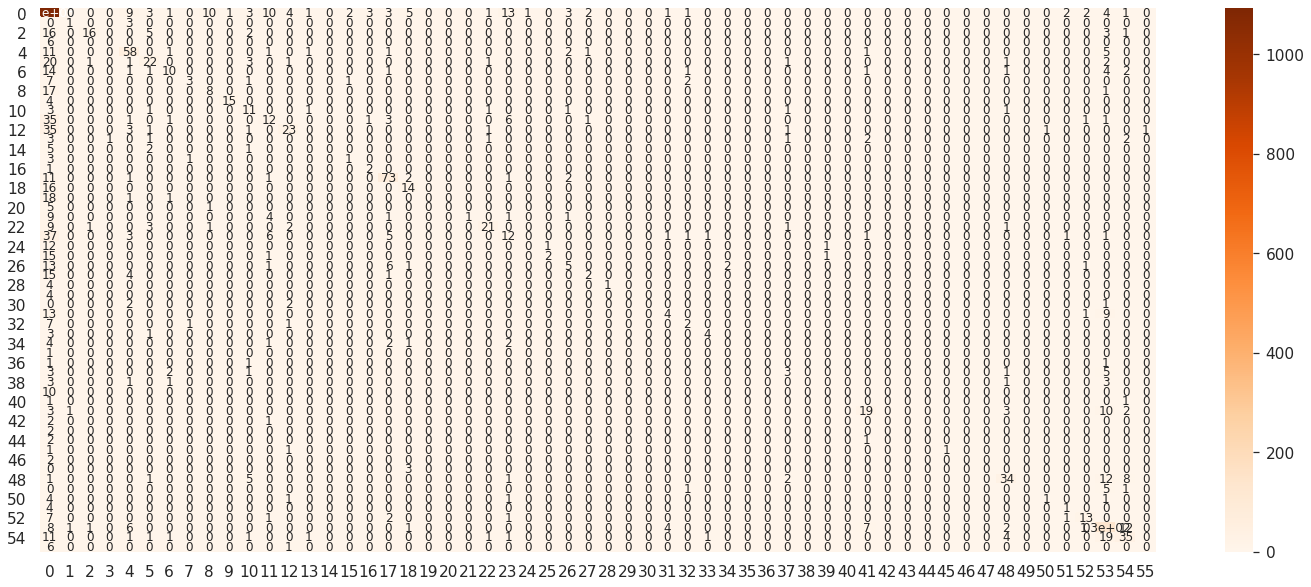

In [83]:
clf = BaggingClassifier(base_estimator=dTree, n_estimators=30,random_state=1).fit(X_train, y_train)
print('train acc: ',clf.score(X_train,y_train))
print('test acc: ',clf.score(X_test, y_test))
precision_recall_fscore_support_roc_auc(clf,y_test,X_test)

train acc:  0.5942963843150568
test acc:  0.5352335708630246
Precision:  0.5352335708630246
Recall:  0.5352335708630246
F1 score:  0.5352335708630246
roc_auc value:  0.6000660468702537


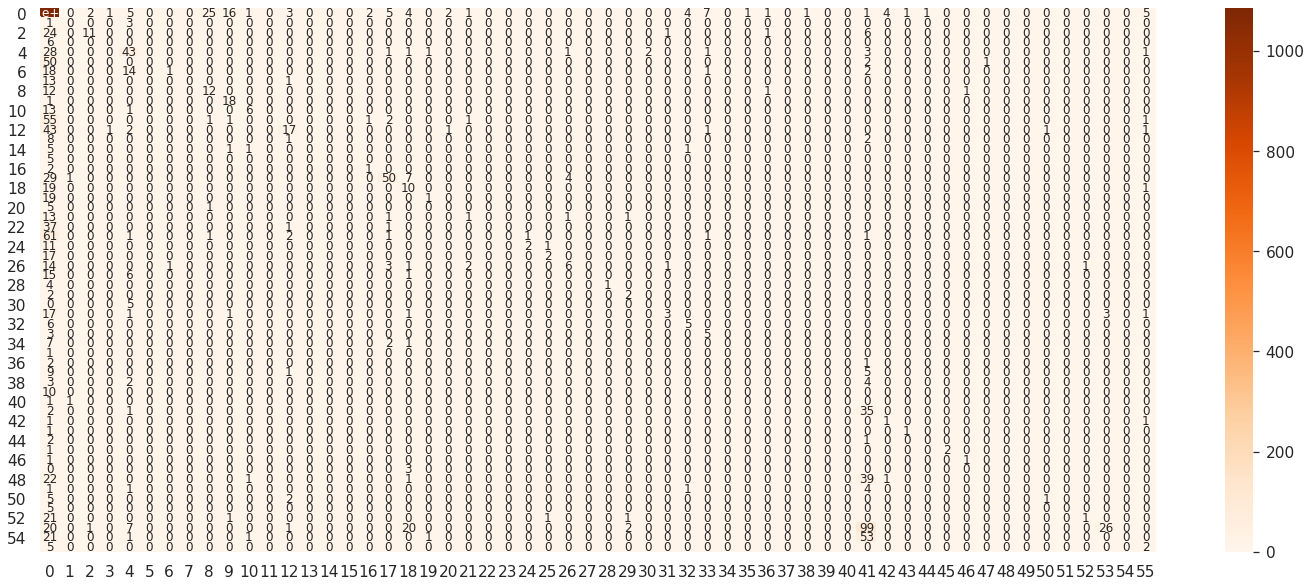

In [84]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
print('train acc: ',clf.score(X_train,y_train))
print('test acc: ',clf.score(X_test, y_test))
precision_recall_fscore_support_roc_auc(clf,y_test,X_test)

train acc:  0.8032592089628247
test acc:  0.6393507521773555
Precision:  0.6393507521773555
Recall:  0.6393507521773555
F1 score:  0.6393507521773555
roc_auc value:  0.8750867111601653


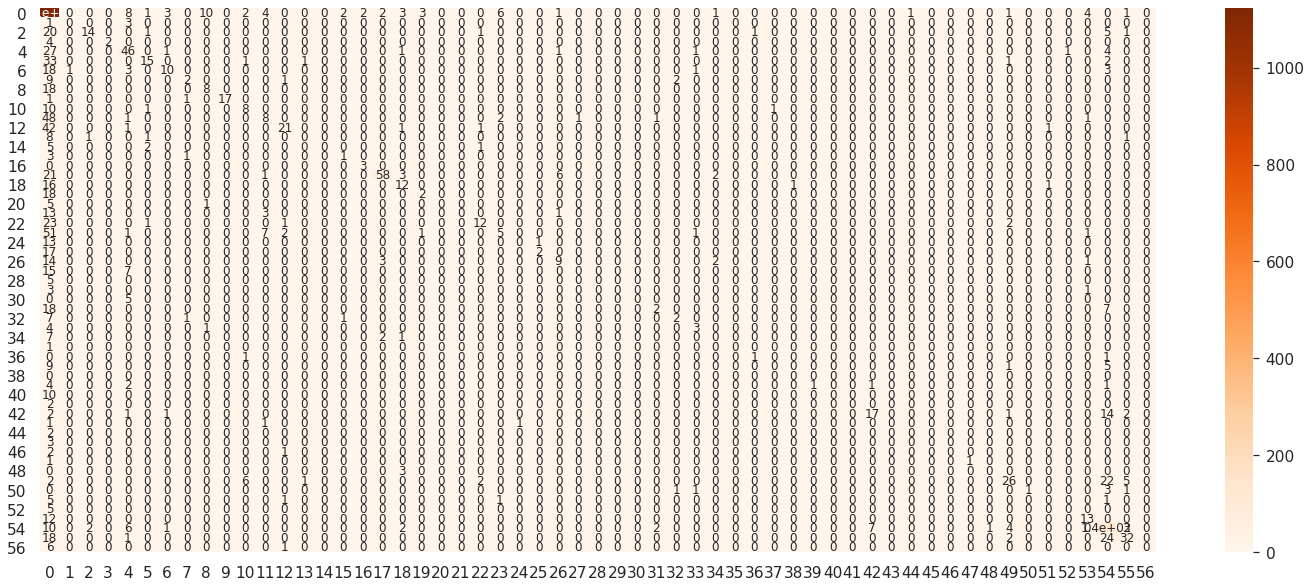

In [85]:
model = XGBClassifier().fit(X_train, y_train)
print('train acc: ',model.score(X_train,y_train))
print('test acc: ',model.score(X_test, y_test))
precision_recall_fscore_support_roc_auc(model,y_test,X_test)

From the confusion matrix we observe many groups are misclassified as GRP_0. May be due to similarity between the corpus.

In [86]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [87]:
num_folds = 50
seed = 7

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
model = LogisticRegression()
results = cross_val_score(model, X, y, cv=kfold)

In [88]:
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.64497041 0.64497041 0.62721893 0.71005917 0.66863905 0.65088757
 0.65680473 0.68639053 0.60946746 0.66863905 0.63905325 0.65088757
 0.66272189 0.66272189 0.62721893 0.6035503  0.67455621 0.5952381
 0.64880952 0.67261905 0.6547619  0.64285714 0.625      0.61309524
 0.69047619 0.60714286 0.60714286 0.625      0.58928571 0.55952381
 0.66666667 0.60714286 0.5952381  0.60714286 0.67857143 0.70833333
 0.68452381 0.70238095 0.6547619  0.66666667 0.70833333 0.63690476
 0.67261905 0.63690476 0.61309524 0.64880952 0.66071429 0.61904762
 0.61904762 0.61904762]
Accuracy: 64.451% (3.391%)


In [89]:
num_folds = 10
seed = 1

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
model = LogisticRegression()
results = cross_val_score(model, X, y, cv=kfold)

In [90]:
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.62232779 0.66864608 0.64489311 0.63420428 0.64726841 0.62826603
 0.6128266  0.63852556 0.65041617 0.62901308]
Accuracy: 63.764% (1.515%)


In [107]:
num_folds = 10
seed = 1

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
model = XGBClassifier()
results = cross_val_score(model, X, y, cv=kfold)

print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.66627078 0.68646081 0.66033254 0.66152019 0.66508314 0.66270784
 0.64251781 0.65517241 0.68846611 0.64328181]
Accuracy: 66.318% (1.447%)


In [111]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from time import time

In [92]:
# build a classifier
clf = RandomForestClassifier(n_estimators=50)

In [93]:
# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [94]:
# run randomized search
samples = 10  # number of random samples 
randomCV = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=samples) #default cv = 3

In [97]:
randomCV.fit(X, y) 
print(randomCV.best_params_)

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 3, 'min_samples_split': 8}


In [98]:
# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [103]:
# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              oob_score=False,
                                              ran

In [104]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 10}

In [105]:
grid_search.cv_results_['mean_test_score']

array([0.46738744, 0.46738744, 0.46738744, 0.46738744, 0.46738744,
       0.46738744, 0.46738744, 0.46738744, 0.46738744, 0.46738744,
       0.46738744, 0.46738744, 0.46738744, 0.46738744, 0.46738744,
       0.46738744, 0.46738744, 0.46738744, 0.46738744, 0.46738744,
       0.46774395, 0.46738744, 0.46738744, 0.46738744, 0.46738744,
       0.46738744, 0.46738744, 0.63205536, 0.63490713, 0.6402538 ,
       0.46738744, 0.46738744, 0.46738744, 0.46738744, 0.46738744,
       0.46738744, 0.63169836, 0.63668803, 0.63977776, 0.46738744,
       0.46738744, 0.46738744, 0.46738744, 0.46738744, 0.46738744,
       0.63561929, 0.6404907 , 0.63953994, 0.48342655, 0.48354539,
       0.48342655, 0.46738744, 0.46738744, 0.46738744, 0.46738744,
       0.46738744, 0.46738744, 0.46738744, 0.46738744, 0.46738744,
       0.46738744, 0.46738744, 0.46738744, 0.46738744, 0.46738744,
       0.46738744, 0.46738744, 0.46738744, 0.46738744, 0.46738744,
       0.46738744, 0.46738744, 0.46738744, 0.46738744, 0.46738

In [106]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [137]:
# build a classifier
clf = XGBClassifier(n_estimators=50, objective="multi:softmax")

In [156]:
# use a full grid over all parameters
param_grid  = {
    "colsample_bytree": [uniform.rvs(0.7, 0.3)],
    "gamma": [uniform.rvs(0, 0.5)],
    "learning_rate": [uniform.rvs(0.03, 0.3)], # default 0.1 
    "max_depth": [sp_randint.rvs(2, 6)], # default 3
    "n_estimators": [sp_randint.rvs(10, 50)], # default 100
    "subsample": [uniform.rvs(0.6, 0.4)]
}

In [157]:
# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=50, n_jobs=1,
                                     nthread=None, objective='multi:softmax',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_po...1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.813032659661663],
                         'gamma': [0.34650654339651255],
                         'learning_rate': [0.328825825679279

In [158]:
grid_search.best_params_

{'colsample_bytree': 0.813032659661663,
 'gamma': 0.34650654339651255,
 'learning_rate': 0.32882582567927987,
 'max_depth': 4,
 'n_estimators': 22,
 'subsample': 0.7364172259237555}

In [159]:
grid_search.cv_results_['mean_test_score']

array([0.61945888])

In [160]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.813032659661663,
              gamma=0.34650654339651255, learning_rate=0.32882582567927987,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
              n_estimators=22, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.7364172259237555, verbosity=1)

In [161]:
num_folds = 10
seed = 1

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.813032659661663,
              gamma=0.34650654339651255, learning_rate=0.32882582567927987,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
              n_estimators=22, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.7364172259237555, verbosity=1)
results = cross_val_score(model, X, y, cv=kfold)

print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.652019   0.66508314 0.65320665 0.64370546 0.6543943  0.65558195
 0.62589074 0.64922711 0.66230678 0.62187872]
Accuracy: 64.833% (1.352%)
